## Theory

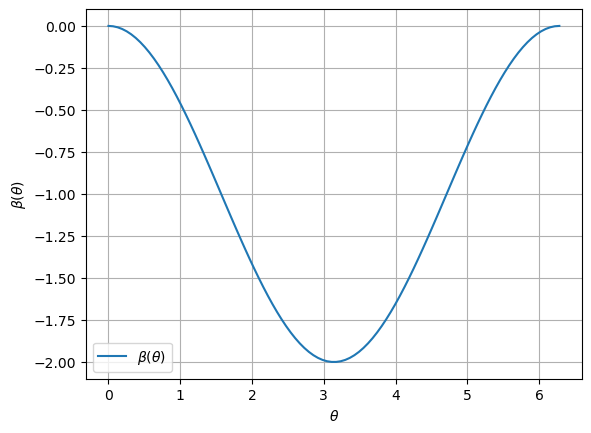

In [9]:
import numpy as np
import matplotlib.pyplot as plt

h = 0.1
k = h**2
mu = 1
r = h**2/(mu*k)

th = np.linspace(0, 2*np.pi, 100)
b = r*(np.cos(th) - 1)

plt.plot(th, b, label=r"$\beta(\theta)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\beta(\theta)$")
plt.legend()
plt.grid()
plt.show()



In [2]:
N = 5
S = [(n, m) for n in range(N) for m in range(N)]
print(f"Length of S: {len(S)}")
print("First few elements:", S[:5])


Length of S: 25
First few elements: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


---

## SIR Model


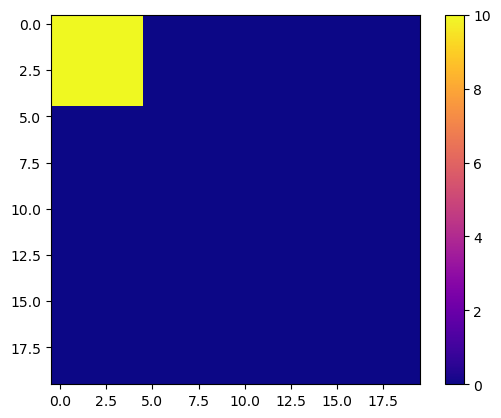

In [3]:
from scipy.sparse import diags, eye, kron

def laplacian(m, n=None):
    if n == None:
        n = m
        
    C_m = diags([-1, 2, -1], [-1, 0, 1], shape=(m, m))
    C_n = diags([-1, 2, -1], [-1, 0, 1], shape=(n, n))

    I_m = eye(m)
    I_n = eye(n)

    D = kron(C_n, I_m) + kron(I_n, C_m)
    return D

M = 20
h = 1/M
beta = 3.0
mu_s = 0.1
mu_i = 0.50

I = np.zeros((M, M))
# Set the initial condition: bottom left corner is 1, rest are 0
I[:5, :5] = 10

plt.imshow(I, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()
dS = laplacian(M)

S = eye(M**2)
SI = eye(M**2).dot(I.flatten('F'))

S_nxt = h*S - h*beta*SI + mu_s/h * dS

In [5]:
import numpy as np
from scipy.sparse import diags, eye, kron
import matplotlib.pyplot as plt

class SIRPDE:
    def __init__(self, M=50, dt=0.001, T=0.1, beta=3.0, gamma=0.1, mu_s=0.1, mu_i=0.5):
        self.M = M
        self.dt = dt
        self.nsteps = int(T / dt)
        self.beta = beta
        self.gamma = gamma
        self.mu_s = mu_s
        self.mu_i = mu_i
        self.h = 1.0 / M
        self.L = self._build_laplacian(M)
        self.L *= 1.0 / (self.h**2)
        self.S = np.ones((M, M))
        self.I = np.zeros((M, M))
        self.I[:10, :10] = 2

    def _build_laplacian(self, m):
        c = diags([-1, 2, -1], [-1, 0, 1], shape=(m, m))
        I_m = eye(m)
        return kron(c, I_m) + kron(I_m, c)

    def _step(self):
        # Reshape 2D arrays to 1D for matrix multiplication
        S_flat = self.S.flatten()
        I_flat = self.I.flatten()
        
        # Calculate changes using flattened arrays
        dS = -self.beta * (self.S * self.I) + self.mu_s * self.L.dot(S_flat).reshape(self.M, self.M)
        dI = self.beta * (self.S * self.I) - self.gamma * self.I + self.mu_i * self.L.dot(I_flat).reshape(self.M, self.M)
        
        # Update states
        self.S += self.dt * dS
        self.I += self.dt * dI

    def solve(self):
        for _ in range(self.nsteps):
            self._step()
        return self.S, self.I



M = 50
mu_s = 0.1
mu_i = 10
beta = 1.5
gamma = 1
h = 1/M
T = 0.1

solver = SIRPDE(M, dt=h, T=T, beta=beta, gamma=gamma, mu_s=mu_s, mu_i=mu_i)

S_list = []
I_list = []

solver = SIRPDE(M=50, dt=0.0005, T=0.05, beta=3.0, mu_s=0.1, mu_i=0.5)

x = np.linspace(0,2,solver.M)
y = np.linspace(0,2,solver.M)
X, Y = np.meshgrid(x, y)
X, Y = X.T, Y.T

for i in range(solver.nsteps):
    solver._step()
    S_list.append(solver.S)
    I_list.append(solver.I)


/var/folders/ln/kg8qyxx52059p3bjyg6mllf40000gn/T/ipykernel_29278/2901176642.py:32: RuntimeWarning: overflow encountered in multiply
  dS = -self.beta * (self.S * self.I) + self.mu_s * self.L.dot(S_flat).reshape(self.M, self.M)
/var/folders/ln/kg8qyxx52059p3bjyg6mllf40000gn/T/ipykernel_29278/2901176642.py:33: RuntimeWarning: overflow encountered in multiply
  dI = self.beta * (self.S * self.I) - self.gamma * self.I + self.mu_i * self.L.dot(I_flat).reshape(self.M, self.M)
/var/folders/ln/kg8qyxx52059p3bjyg6mllf40000gn/T/ipykernel_29278/2901176642.py:32: RuntimeWarning: invalid value encountered in add
  dS = -self.beta * (self.S * self.I) + self.mu_s * self.L.dot(S_flat).reshape(self.M, self.M)
/var/folders/ln/kg8qyxx52059p3bjyg6mllf40000gn/T/ipykernel_29278/2901176642.py:33: RuntimeWarning: invalid value encountered in subtract
  dI = self.beta * (self.S * self.I) - self.gamma * self.I + self.mu_i * self.L.dot(I_flat).reshape(self.M, self.M)
/var/folders/ln/kg8qyxx52059p3bjyg6mllf40000g

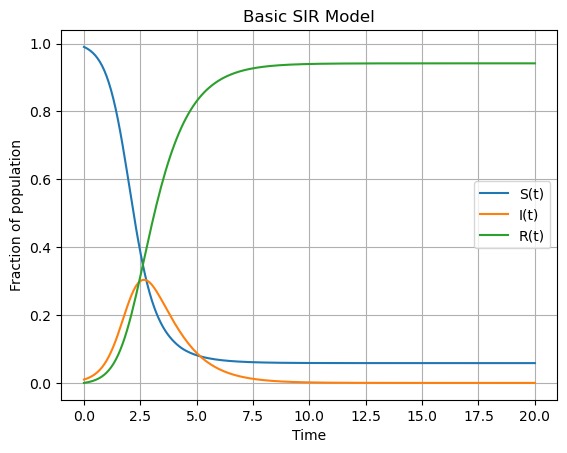

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def sir_ode(t, y, beta, gamma):
    S, I = y
    R = 1 - S - I  # Not needed directly for the ODE, but good to keep track
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    return [dSdt, dIdt]

# Parameters
beta = 3.0
gamma = 1.0

# Initial conditions
S0 = 0.99
I0 = 0.01
y0 = [S0, I0]

# Time span
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 200)

# Solve
sol = solve_ivp(sir_ode, t_span, y0, args=(beta, gamma), t_eval=t_eval)

# Extract solutions
S_vals = sol.y[0]
I_vals = sol.y[1]
R_vals = 1 - S_vals - I_vals

# Plot
plt.figure()
plt.plot(sol.t, S_vals, label='S(t)')
plt.plot(sol.t, I_vals, label='I(t)')
plt.plot(sol.t, R_vals, label='R(t)')
plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.title('Basic SIR Model')
plt.grid(True)
plt.show()


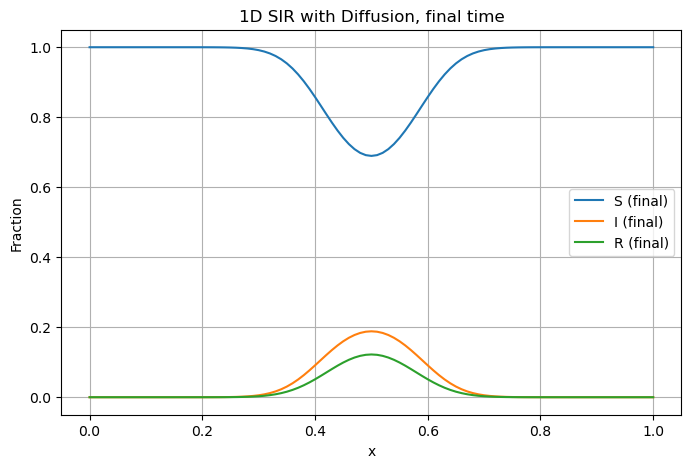

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
beta = 3.0      # Infection rate
gamma = 1.0     # Recovery/removal rate
mu_S = 0.001    # Diffusion of S
mu_I = 0.001    # Diffusion of I

# Spatial domain
L = 1.0         # domain is x in [0, L]
N = 101         # number of grid points
dx = L / (N-1)
x = np.linspace(0, L, N)

# Time discretization
dt = 0.0001     # pick small dt for stability
t_final = 2.0
num_steps = int(t_final / dt)

# Initial condition
S = np.ones(N)
I = np.zeros(N)

# Make a small “bump” of infection in the middle
# e.g. between x=0.45 and x=0.55
for j in range(N):
    if 0.45 <= x[j] <= 0.55:
        I[j] = 0.01
        S[j] = 0.99
    else:
        I[j] = 0.0
        S[j] = 1.0

# Storage for solution at each time step (if you want to animate or record data)
S_solutions = []
I_solutions = []
time_points = []

# Time stepping
for n in range(num_steps):
    # Store for plotting
    if n % 100 == 0:
        S_solutions.append(S.copy())
        I_solutions.append(I.copy())
        time_points.append(n*dt)
    
    # Create copies for the updates
    S_new = S.copy()
    I_new = I.copy()
    
    # Compute derivatives in the interior using a simple 3-point stencil
    for j in range(1, N-1):
        # 2nd derivative for S
        d2Sdx2 = (S[j+1] - 2*S[j] + S[j-1]) / (dx*dx)
        # 2nd derivative for I
        d2Idx2 = (I[j+1] - 2*I[j] + I[j-1]) / (dx*dx)
        
        # PDE update
        S_new[j] = S[j] + dt * ( -beta * S[j] * I[j] + mu_S * d2Sdx2 )
        I_new[j] = I[j] + dt * (  beta * S[j] * I[j] - gamma * I[j] + mu_I * d2Idx2 )
    
    # Handle boundary (no-flux) with reflection
    S_new[0] = S_new[1]
    S_new[-1] = S_new[-2]
    I_new[0] = I_new[1]
    I_new[-1] = I_new[-2]
    
    # Update
    S = S_new
    I = I_new

# Plot final profiles
plt.figure(figsize=(8,5))
plt.plot(x, S, label='S (final)')
plt.plot(x, I, label='I (final)')
plt.plot(x, 1 - S - I, label='R (final)')
plt.xlabel('x')
plt.ylabel('Fraction')
plt.title('1D SIR with Diffusion, final time')
plt.legend()
plt.grid(True)
plt.show()


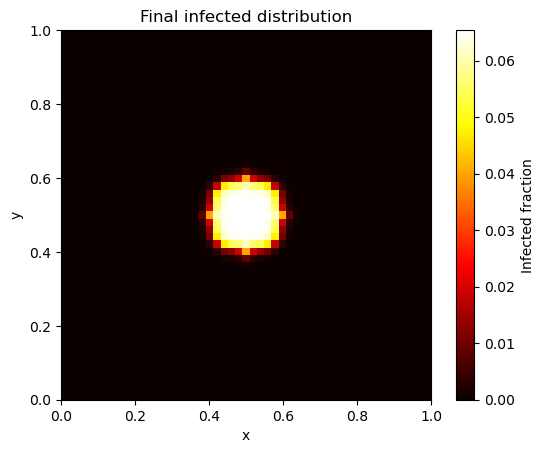

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
beta = 3.0
gamma = 1.0
mu_S = 0.0001
mu_I = 0.0001

# Domain
Lx = 1.0
Ly = 1.0
Nx = 51
Ny = 51
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Time
dt = 0.0001
t_final = 1.0
num_steps = int(t_final/dt)

# Initialize S, I in 2D
S = np.ones((Nx, Ny))
I = np.zeros((Nx, Ny))

# Infect a small region near the center
ix_center = Nx//2
iy_center = Ny//2
radius = 5
for i in range(Nx):
    for j in range(Ny):
        if (i - ix_center)**2 + (j - iy_center)**2 <= radius**2:
            I[i,j] = 0.01
            S[i,j] = 0.99

# Time stepping
for n in range(num_steps):
    S_new = S.copy()
    I_new = I.copy()
    
    # Laplacian in 2D
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            d2Sdx2 = (S[i+1,j] - 2*S[i,j] + S[i-1,j]) / (dx*dx)
            d2Sdy2 = (S[i,j+1] - 2*S[i,j] + S[i,j-1]) / (dy*dy)
            lapS = d2Sdx2 + d2Sdy2

            d2Idx2 = (I[i+1,j] - 2*I[i,j] + I[i-1,j]) / (dx*dx)
            d2Idy2 = (I[i,j+1] - 2*I[i,j] + I[i,j-1]) / (dy*dy)
            lapI = d2Idx2 + d2Idy2
            
            S_new[i,j] = S[i,j] + dt * ( -beta*S[i,j]*I[i,j] + mu_S*lapS )
            I_new[i,j] = I[i,j] + dt * (  beta*S[i,j]*I[i,j] - gamma*I[i,j] + mu_I*lapI )

    # Boundary conditions (no-flux)
    # Simple approach: set boundary values by reflecting adjacent interior points
    S_new[0,:]   = S_new[1,:]
    S_new[-1,:]  = S_new[-2,:]
    S_new[:,0]   = S_new[:,1]
    S_new[:,-1]  = S_new[:, -2]
    I_new[0,:]   = I_new[1,:]
    I_new[-1,:]  = I_new[-2,:]
    I_new[:,0]   = I_new[:,1]
    I_new[:,-1]  = I_new[:, -2]
    
    S = S_new
    I = I_new

# Plot final state
plt.figure()
plt.imshow(I.T, origin='lower', extent=[0,Lx,0,Ly], cmap='hot')
plt.colorbar(label='Infected fraction')
plt.title('Final infected distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
